In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Ryan Jewik\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Ryan Jewik\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [11]:
df = pd.read_csv('../final/o-kids-math-games.csv')

In [22]:
df = pd.read_excel("../Deductive_Analysis_Results.xlsx")

In [ ]:
df.rename(columns={'Sentence': 'review'}, inplace=True)
df.rename(columns={'Code': 'Name'}, inplace=True)

In [24]:
df['Code'].value_counts()

Code
Creative : Engaging/Fun                          84
Engaging/Fun : Education                         49
Goal oriented : Education                        48
Engaging/Fun : Quality Screen Time               22
Other                                            19
                                                 ..
Over Stimulated : Goal oriented                   1
Personalization/Variety : Ease of Use             1
Ease of Use : Language                            1
Goal oriented : Open-Ended/Explore                1
Open-Ended/Explore : Goal oriented : Creative     1
Name: count, Length: 120, dtype: int64

In [26]:
creative = df[df['Code'] == 'Creative : Engaging/Fun']
creative

,review,Code,Probability,Justification,Source File
180,nice super thankyou,Creative : Engaging/Fun,0.7,"The use of the word ""nice"" and ""super"" suggest...",g-kids-math-games.csv
184,good like,Creative : Engaging/Fun,0.5,"The use of the word ""good"" suggests positive f...",g-kids-math-games.csv
192,awesome interesting,Creative : Engaging/Fun,0.7,"The sentence ""awesome interesting"" suggests a ...",g-kids-math-games.csv
196,happy,Creative : Engaging/Fun,0.7,"The word ""happy"" suggests a positive emotion a...",g-kids-math-games.csv
200,good nice,Creative : Engaging/Fun,0.5,"The words ""good"" and ""nice"" suggest positive q...",g-kids-math-games.csv
...,...,...,...,...,...
463,nice,Creative : Engaging/Fun,0.5,"The word ""nice"" could be associated with activ...",g-kids-math-games.csv
468,good,Creative : Engaging/Fun,0.5,"The word ""good"" can be associated with creativ...",g-kids-math-games.csv
469,good,Creative : Engaging/Fun,0.5,"The word ""good"" can be associated with creativ...",g-kids-math-games.csv
470,good,Creative : Engaging/Fun,0.5,"The word ""good"" can be associated with creativ...",g-kids-math-games.csv


In [19]:
df['Code'].value_counts().nunique()

18

In [28]:
from transformers import pipeline
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

In [27]:
def analyze_app_emotions(reviews, app_name):
    emotions_df = pd.DataFrame()
    skipped_count = 0
    
    for review in reviews:
        try:
            # Get emotions for current review
            emotions = classifier(review)
            
            # Create dictionary mapping labels to scores
            row_data = {'review': review, 'Name': app_name}
            for emotion in emotions[0]:
                row_data[emotion['label']] = emotion['score']
                
            # Convert to DataFrame row and concatenate
            review_df = pd.DataFrame([row_data])
            emotions_df = pd.concat([emotions_df, review_df], ignore_index=True)
            
        except RuntimeError as e:
            skipped_count += 1
            continue
    
    return emotions_df

In [55]:
emotion_df = analyze_app_emotions(df['review'], df['Name'].iloc[0])

In [29]:
emotion_df = analyze_app_emotions(creative['review'], creative['Code'].iloc[0])

In [56]:
emotion_df.shape

(8, 30)

In [61]:
emotion_df.iloc[6]['review']

'ethan gay roger 13550 ethan is 4 years old and\nmommy is 45 years old and\ndaddy is 61 years old and\nellie is 7 years old'

In [58]:
emotion_df.columns

Index(['review', 'Name', 'gratitude', 'admiration', 'love', 'joy', 'approval',
       'excitement', 'optimism', 'caring', 'pride', 'realization', 'relief',
       'neutral', 'desire', 'annoyance', 'sadness', 'disapproval', 'anger',
       'confusion', 'surprise', 'disappointment', 'remorse', 'amusement',
       'curiosity', 'disgust', 'grief', 'fear', 'embarrassment',
       'nervousness'],
      dtype='object')

In [30]:
#functions
def create_emotion_spider(emotions_df, title_suffix, color, figsize):
    # Create buffer to store image
    from io import BytesIO
    import base64
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Calculate means and get top 6
    emotion_means = emotions_df.drop(['review', 'Name'], axis=1).mean()
    top_emotions = dict(sorted(emotion_means.items(), key=lambda x: x[1], reverse=True)[:6])
    
    # Prepare data
    emotions = [emotion.capitalize() for emotion in top_emotions.keys()]
    values = list(top_emotions.values())
    
    # Setup angles
    num_vars = len(emotions)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]
    values += values[:1]
    
    # Plot data
    ax.plot(angles, values, 'o-', linewidth=2, color=color, label='Top 6 Emotions')
    ax.fill(angles, values, alpha=0.25, color=color)
    
    # Customize chart
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(emotions, size=10)
    ax.set_rgrids([0.1, 0.2, 0.3, 0.4, 0.5])
    
    plt.title(f"Emotional Analysis: {title_suffix}", size=15, y=1.05)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    
    # Save plot to buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image_png = buffer.getvalue()
    graph = base64.b64encode(image_png).decode('utf-8')
    buffer.close()
    plt.show()
    # Clear the current figure
    plt.close()
    
    # Encode
    
    
    return graph

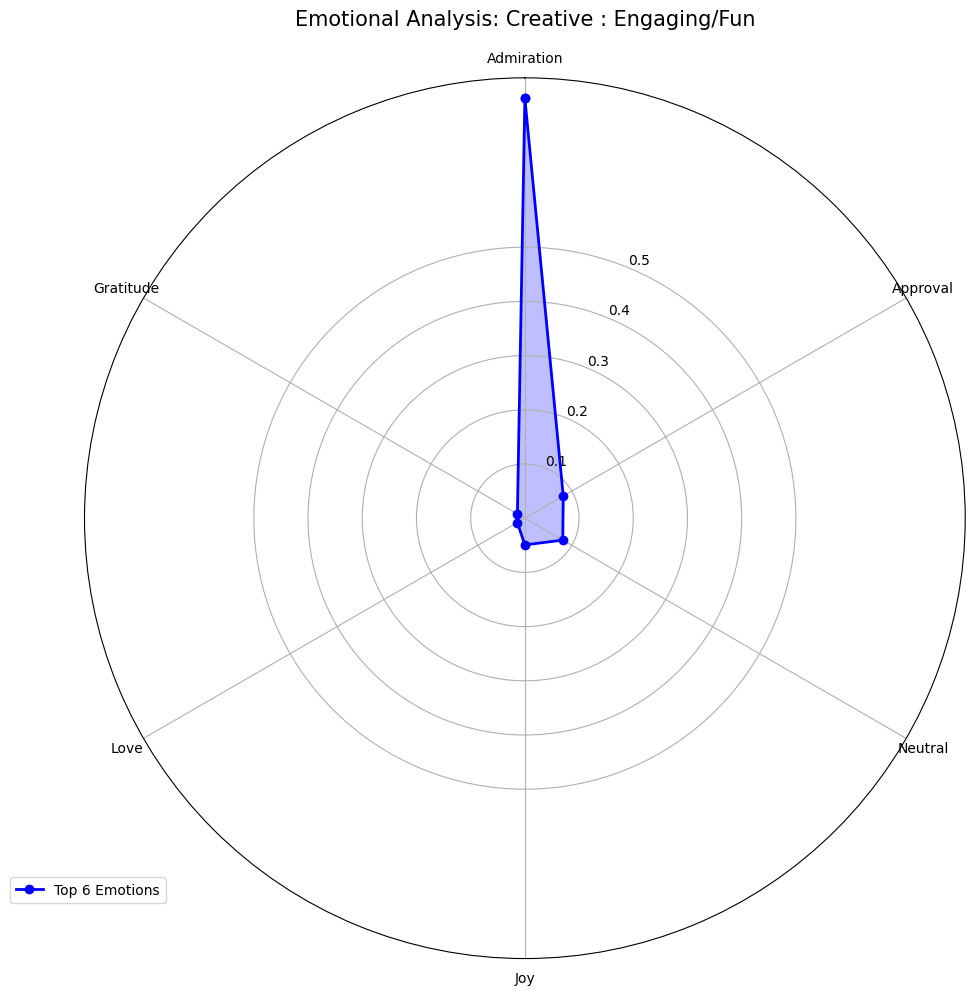

In [36]:
img = create_emotion_spider(emotion_df, creative['Code'].iloc[0], 'blue', (10, 10))

KeyError: "['Name'] not found in axis"

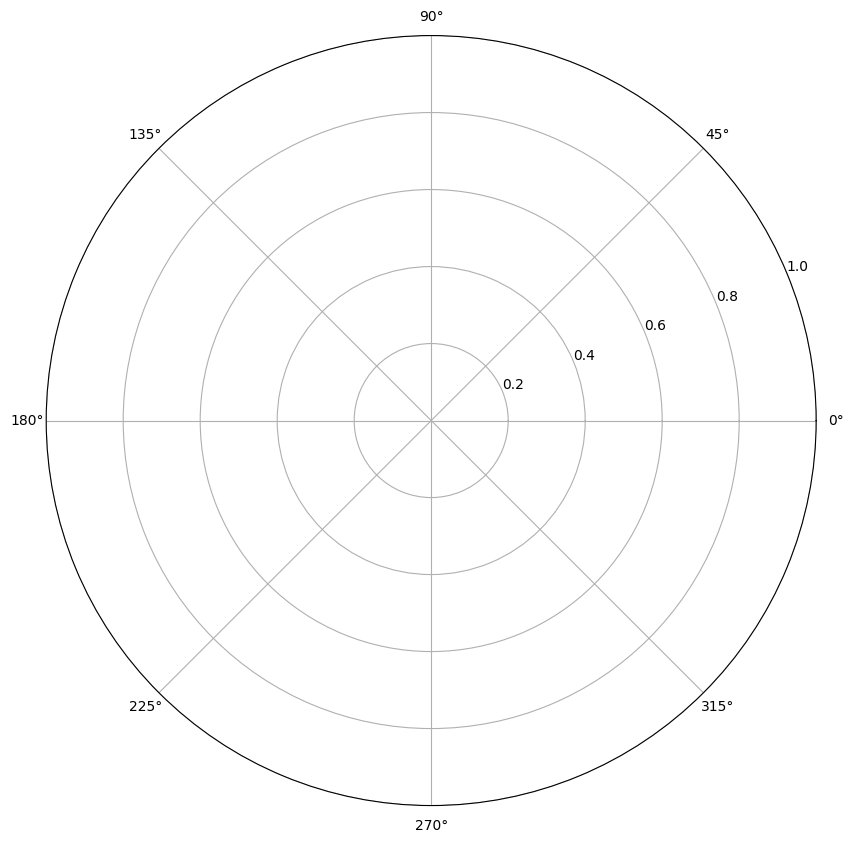

In [ ]:
# Generate graph
img = create_emotion_spider(emotion_df, df['Name'].iloc[0], 'blue', (10, 10))

trying to combine

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64

def create_combined_emotion_spider(df1, df2, df3, title_suffix, colors, figsize=(10, 10)):
    # Combine the dataframes
    combined_df = pd.concat([df1, df2, df3])
    
    # Calculate means and get top 6 emotions
    emotion_means = combined_df.drop(['review', 'Name'], axis=1).mean()
    top_emotions = dict(sorted(emotion_means.items(), key=lambda x: x[1], reverse=True)[:6])
    
    # Prepare data
    emotions = [emotion.capitalize() for emotion in top_emotions.keys()]
    num_vars = len(emotions)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection='polar'))
    
    # Plot each dataframe
    for i, df in enumerate([df1, df2, df3]):
        emotion_means = df.drop(['review', 'Name'], axis=1).mean()
        values = [emotion_means.get(emotion.lower(), 0) for emotion in emotions]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, color=colors[i], label=f'DataFrame {i+1}')
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    # Customize chart
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(emotions, size=10)
    ax.set_rgrids([0.1, 0.2, 0.3, 0.4, 0.5])
    
    plt.title(f"Emotional Analysis: {title_suffix}", size=15, y=1.05)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    
    # Save plot to buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image_png = buffer.getvalue()
    graph = base64.b64encode(image_png).decode('utf-8')
    buffer.close()
    plt.show()
    plt.close()
    
    return graph

In [40]:
df['Code'].value_counts()

Code
Creative : Engaging/Fun                          84
Engaging/Fun : Education                         49
Goal oriented : Education                        48
Engaging/Fun : Quality Screen Time               22
Other                                            19
                                                 ..
Over Stimulated : Goal oriented                   1
Personalization/Variety : Ease of Use             1
Ease of Use : Language                            1
Goal oriented : Open-Ended/Explore                1
Open-Ended/Explore : Goal oriented : Creative     1
Name: count, Length: 120, dtype: int64

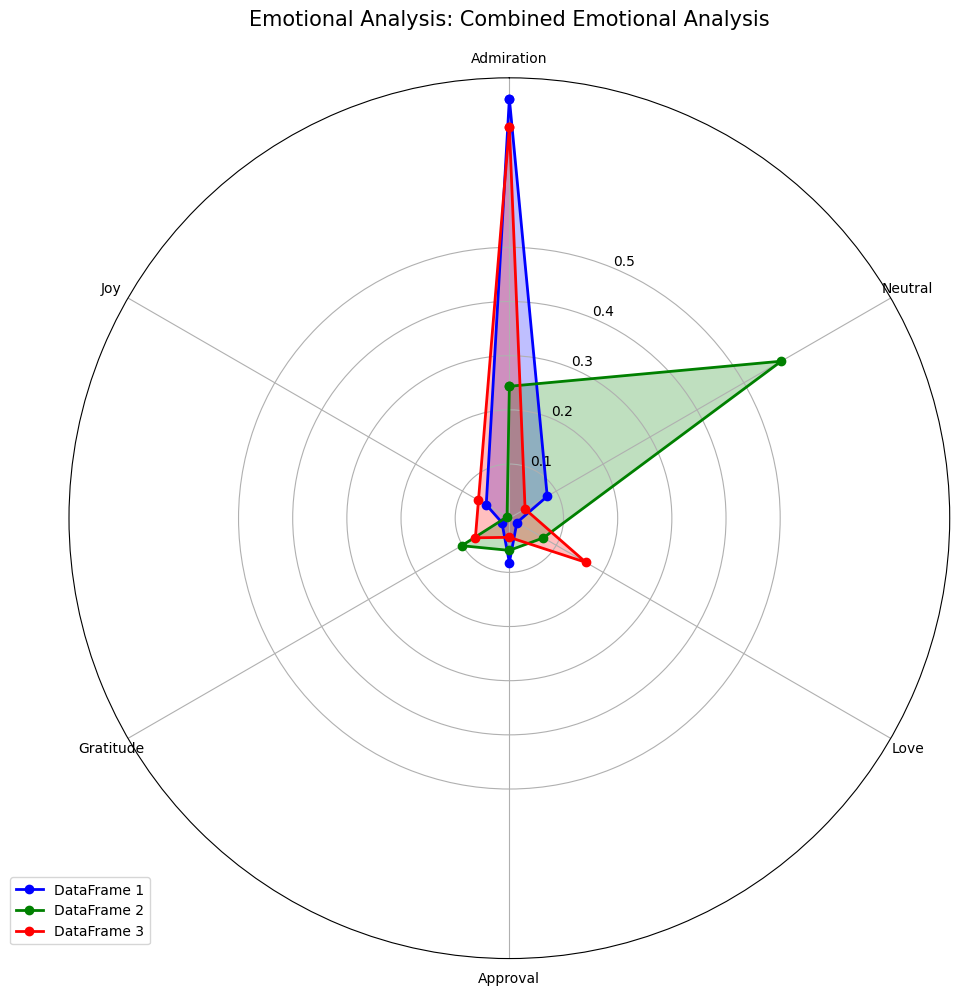

In [55]:

# Example usage
df1 = df[df['Name'] == 'Creative : Engaging/Fun']
emotion_df1 = analyze_app_emotions(df1['review'], df1['Name'].iloc[0])
df2 = df[df['Name'] == 'Goal oriented : Education']
emotion_df2 = analyze_app_emotions(df2['review'], df2['Name'].iloc[0])
df3 = df[df['Name'] == 'Engaging/Fun : Education']
emotion_df3 = analyze_app_emotions(df3['review'], df3['Name'].iloc[0])

# Assuming the dataframes have a 'review' and 'Name' column, and emotion columns
img = create_combined_emotion_spider(emotion_df1, emotion_df2, emotion_df3, 'Combined Emotional Analysis', ['blue', 'green', 'red'])

In [54]:
df3

,review,Name,Probability,Justification,Source File
